In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data into a pandas DataFrame
data = pd.read_csv('GazeData/gaze_data_all_trials_jenna.csv', sep=',')

# Define screen resolution (you can adjust this based on Unity's settings)
screen_width = 3840
screen_height = 2160

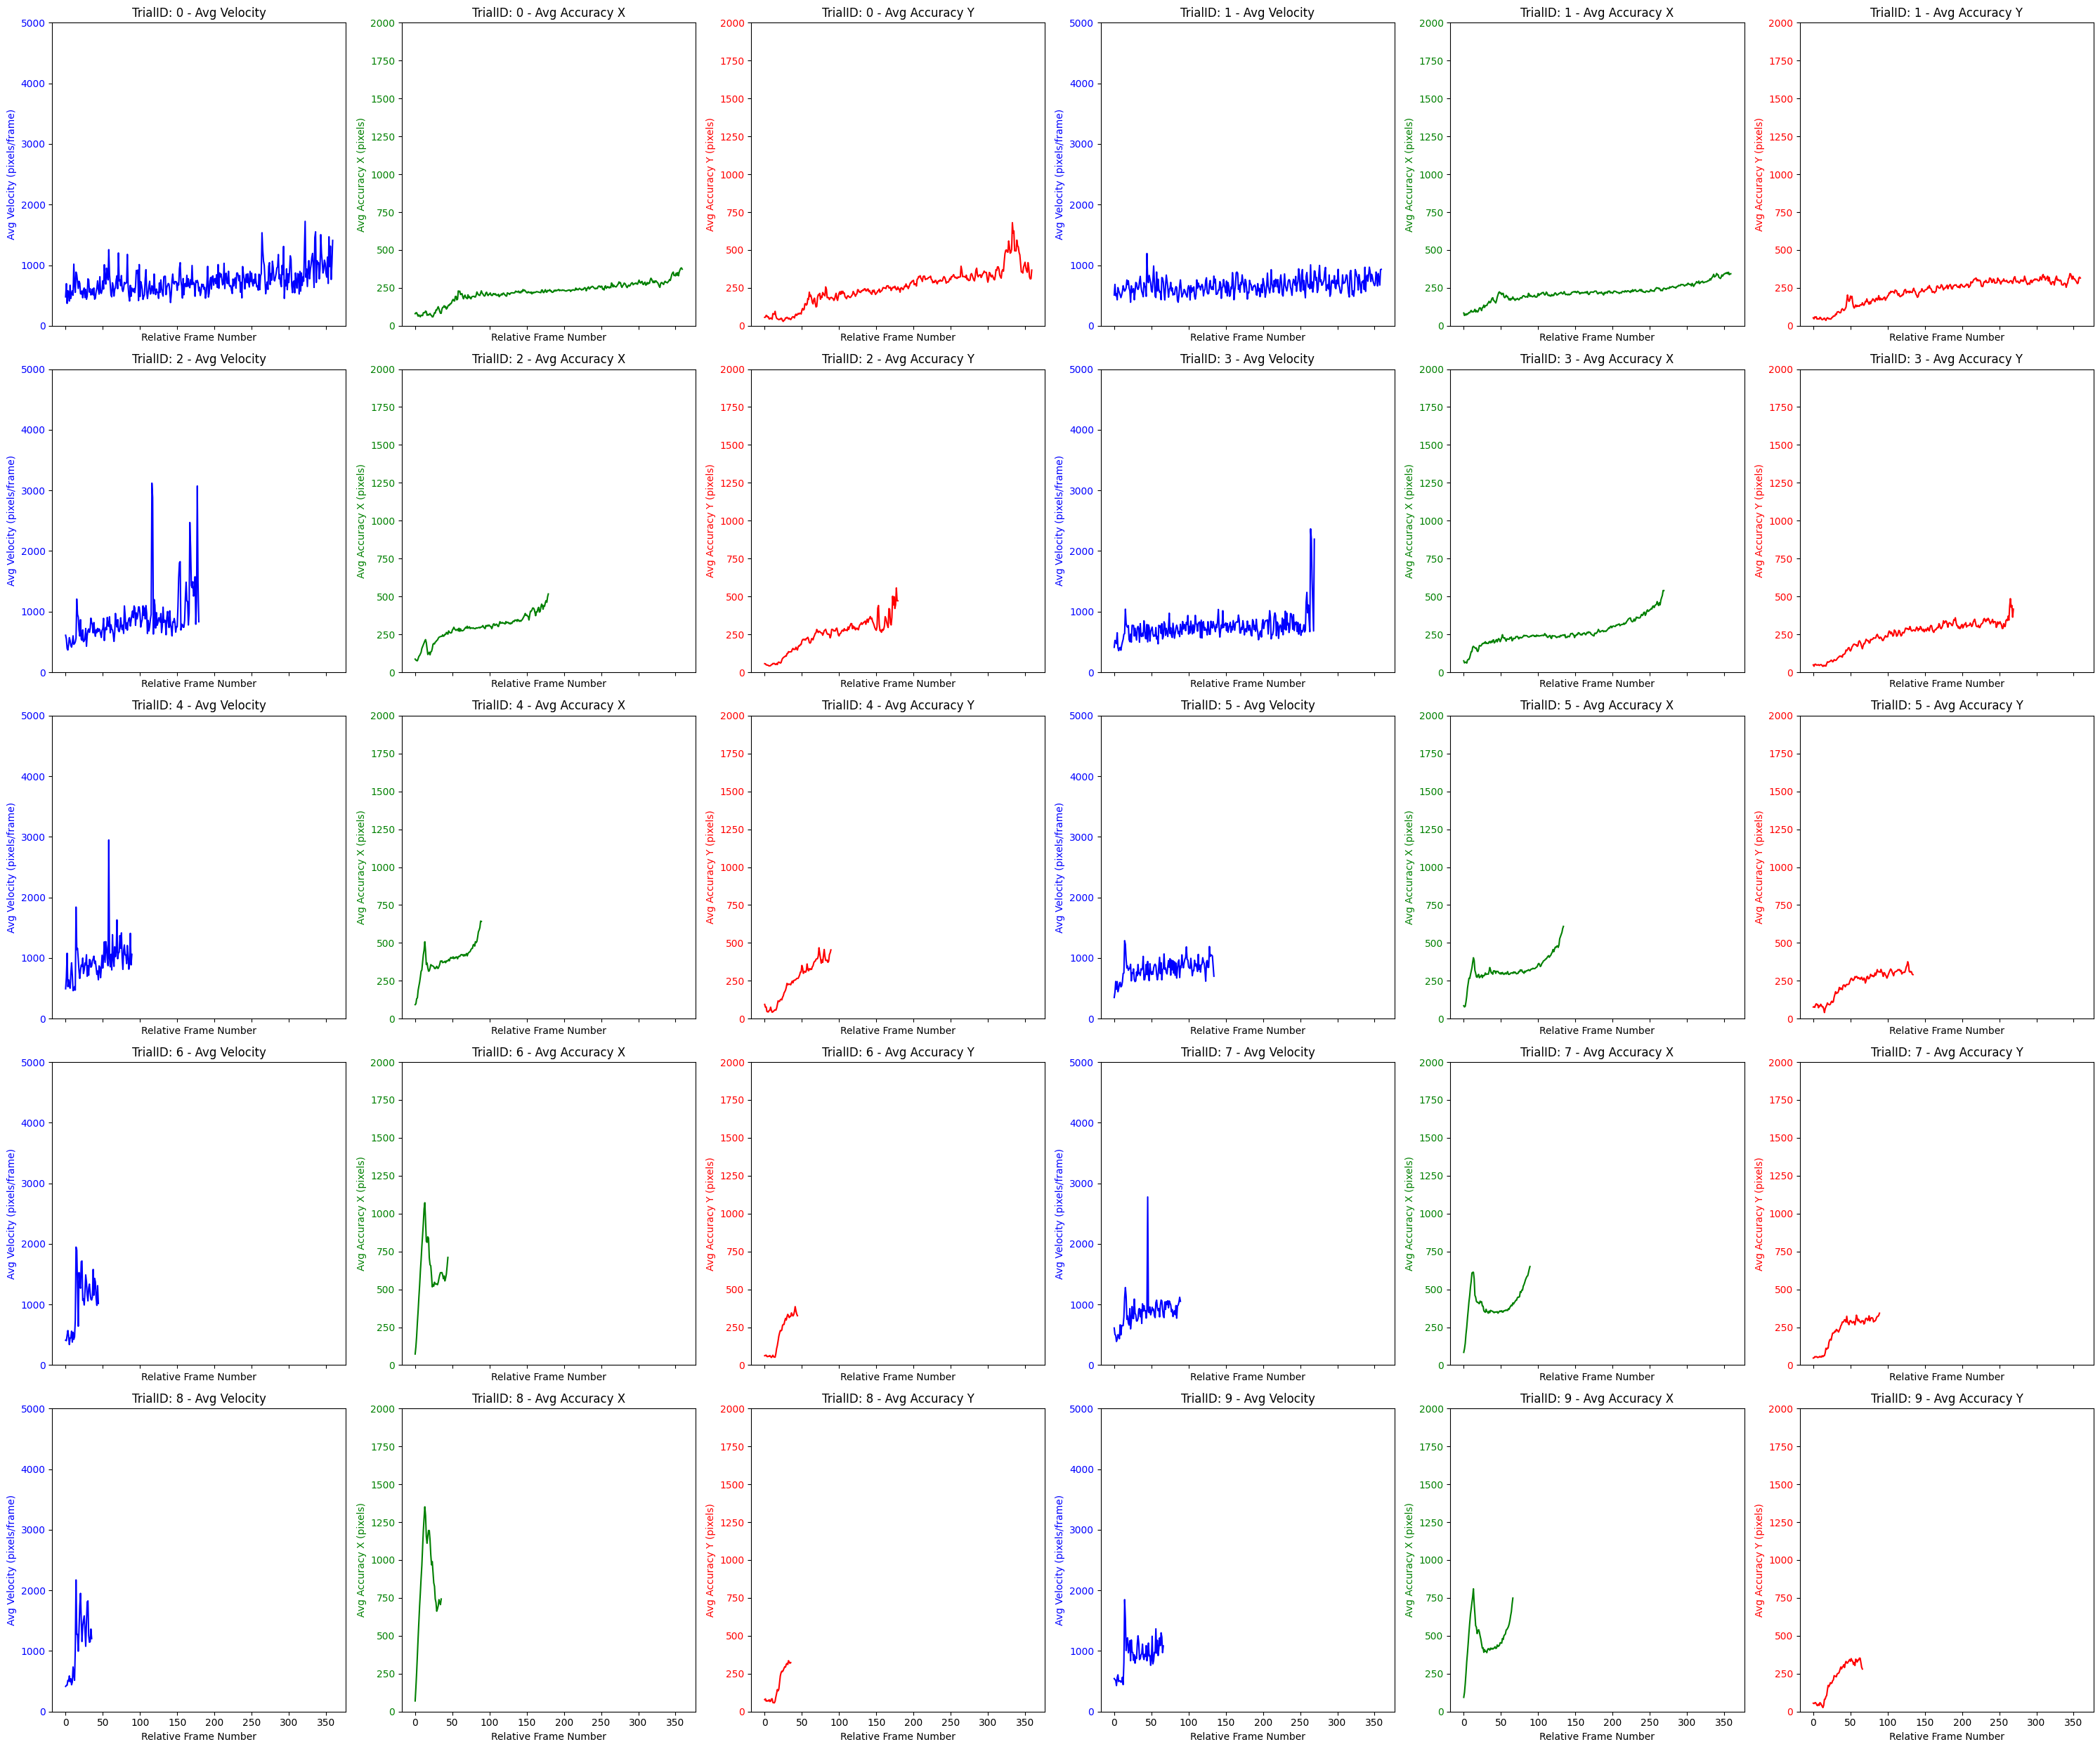

In [34]:

# Step 1: Compute Eye Movement Velocity
def compute_velocity(df):
    df['FrameDiff'] = df['RelativeFrameNumber'].diff().fillna(1)  # Avoid division by zero, fill NaN with 1
    df['PosDiff'] = np.sqrt((df['BestPogX'].diff() ** 2) + (df['BestPogY'].diff() ** 2))
    df['PosDiff'].fillna(0, inplace=True)  # Replace NaN with 0
    df['Velocity'] = df['PosDiff'] / df['FrameDiff'].replace(0, 1e-5)  # Replace zero with a small value
    return df

# Step 2: Compute Accuracy Relative to the Ball Position (separate X and Y)
def compute_accuracy(df, screen_width, screen_height):
    df['MappedPogX'] = df['BestPogX'] * screen_width
    df['MappedPogY'] = df['BestPogY'] * screen_height

    df[['BallX', 'BallY']] = df['ScreenBallPosition'].str.extract(r'\((\d+\.?\d*)\s(\d+\.?\d*)\s\d+\.?\d*\)').astype(float)
    df['AccuracyX'] = np.abs(df['MappedPogX'] - df['BallX'])
    df['AccuracyY'] = np.abs(df['MappedPogY'] - df['BallY'])
    return df

# Step 1: Align frame numbers and average across trials of the same type (trialID)
def align_and_average_across_trials(df, screen_width, screen_height):
    # Align Frame Numbers: Create RelativeFrameNumber for each trial
    df['RelativeFrameNumber'] = df.groupby('TrialNumber')['FrameNumber'].transform(lambda x: x - x.min())
    
    # Compute Velocity and Accuracy
    df = compute_velocity(df)
    df = compute_accuracy(df, screen_width, screen_height)
    
    # Find the maximum duration (relative frame number) for each trialID
    max_duration = df.groupby('TrialID')['RelativeFrameNumber'].max().max()

    # Step 2: Interpolate missing values for shorter trials
    all_relative_frames = pd.DataFrame({'RelativeFrameNumber': np.arange(max_duration + 1)})
    avg_df = []
    
    for trial_id in df['TrialID'].unique():
        trial_data = df[df['TrialID'] == trial_id]
        
        # Group by TrialNum to align and interpolate each trial
        # trial_grouped = trial_data.groupby('TrialNumber').apply(lambda group: group.set_index('RelativeFrameNumber').reindex(np.arange(max_duration + 1)).interpolate(limit_direction='both', method='linear')).reset_index()

        # Now average across all trials of the same type (trialID)
        avg_by_trial_id = trial_data.groupby('RelativeFrameNumber').agg(
            AvgVelocity=('Velocity', 'mean'),
            AvgAccuracyX=('AccuracyX', 'mean'),
            AvgAccuracyY=('AccuracyY', 'mean')
        ).reset_index()
        
        avg_by_trial_id['TrialID'] = trial_id
        avg_df.append(avg_by_trial_id)

    # Concatenate all averaged trials
    avg_df = pd.concat(avg_df)
    return avg_df

# Step 3: Plot the aligned and averaged metrics by trialID
def plot_aligned_average_metrics_by_trialID(avg_df, screen_width, screen_height):
    trial_ids = sorted(avg_df['TrialID'].unique())  # Ensure TrialIDs are ordered
    num_trials = len(trial_ids)
    num_rows = (num_trials + 1) // 2  # Each row contains 2 trials

    # Create subplots: 6 columns (2 trials per row, each with velocity and X/Y accuracy)
    fig, axes = plt.subplots(num_rows, 6, figsize=(30, 5 * num_rows), sharex=True)

    for i, trial_id in enumerate(trial_ids):
        trial_avg = avg_df[avg_df['TrialID'] == trial_id]

        row = i // 2
        col_velocity = (i % 2) * 3  # First column for velocity
        col_accuracy_x = col_velocity + 1  # Second column for X accuracy
        col_accuracy_y = col_velocity + 2  # Third column for Y accuracy

        # Plot average Velocity in the first column for each trialID
        ax_velocity = axes[row, col_velocity]
        ax_velocity.plot(trial_avg['RelativeFrameNumber'], trial_avg['AvgVelocity'], color='blue', label='Avg Velocity')
        ax_velocity.set_ylabel('Avg Velocity (pixels/frame)', color='blue')
        ax_velocity.tick_params(axis='y', labelcolor='blue')
        ax_velocity.set_title(f'TrialID: {trial_id} - Avg Velocity')
        ax_velocity.set_ylim([0, 5000])
        ax_velocity.set_xlabel('Relative Frame Number')

        # Plot average Accuracy (X) in the second column for each trial
        ax_accuracy_x = axes[row, col_accuracy_x]
        ax_accuracy_x.plot(trial_avg['RelativeFrameNumber'], trial_avg['AvgAccuracyX'], color='green', label='Avg Accuracy X')
        ax_accuracy_x.set_ylabel('Avg Accuracy X (pixels)', color='green')
        ax_accuracy_x.tick_params(axis='y', labelcolor='green')
        ax_accuracy_x.set_title(f'TrialID: {trial_id} - Avg Accuracy X')
        ax_accuracy_x.set_ylim([0, 2000])
        ax_accuracy_x.set_xlabel('Relative Frame Number')

        # Plot average Accuracy (Y) in the third column for each trial
        ax_accuracy_y = axes[row, col_accuracy_y]
        ax_accuracy_y.plot(trial_avg['RelativeFrameNumber'], trial_avg['AvgAccuracyY'], color='red', label='Avg Accuracy Y')
        ax_accuracy_y.set_ylabel('Avg Accuracy Y (pixels)', color='red')
        ax_accuracy_y.tick_params(axis='y', labelcolor='red')
        ax_accuracy_y.set_title(f'TrialID: {trial_id} - Avg Accuracy Y')
        ax_accuracy_y.set_ylim([0, 2000])
        ax_accuracy_y.set_xlabel('Relative Frame Number')

    fig.tight_layout()
    plt.show()

# Step 4: Align, average, and plot metrics
aligned_avg_data_by_trial = align_and_average_across_trials(data, screen_width, screen_height)
plot_aligned_average_metrics_by_trialID(aligned_avg_data_by_trial, screen_width, screen_height)


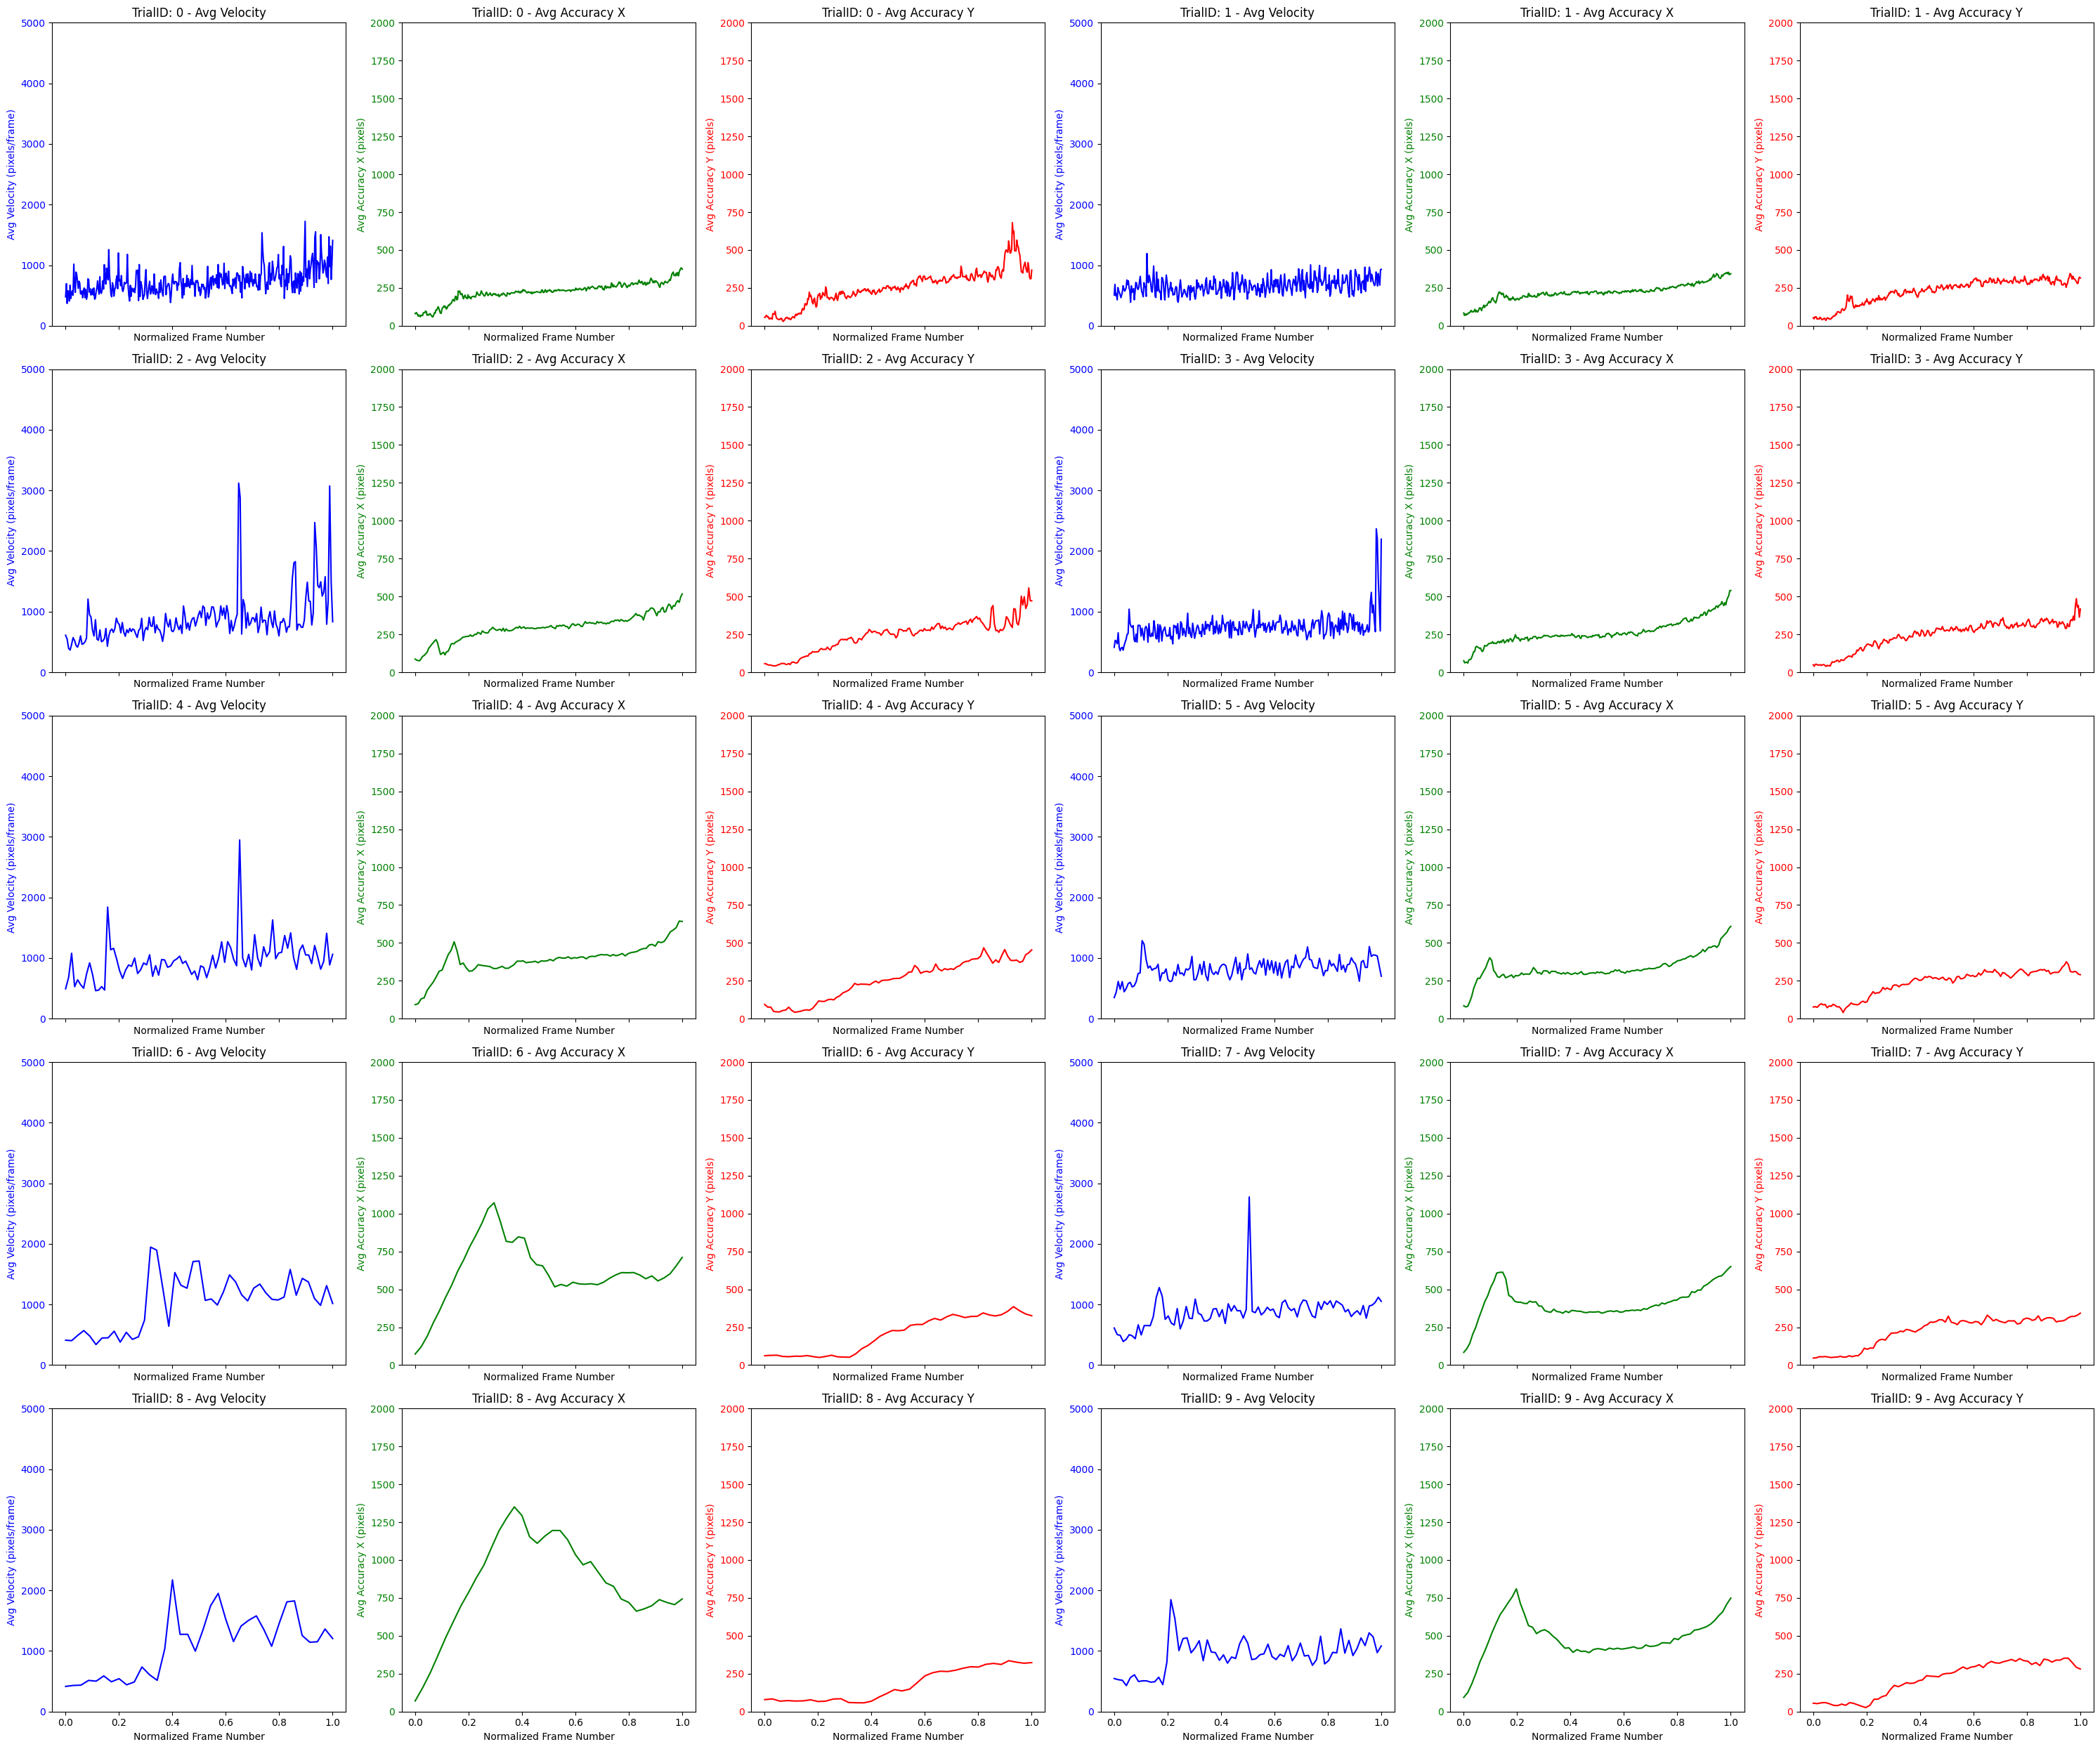

In [35]:
# Step 1: Align frame numbers, normalize to [0, 1], and average across trials of the same type (trialID)
def align_and_average_across_trials(df, screen_width, screen_height):
    # Align Frame Numbers: Create RelativeFrameNumber for each trial
    df['RelativeFrameNumber'] = df.groupby('TrialNumber')['FrameNumber'].transform(lambda x: x - x.min())
    
    # Compute Velocity and Accuracy
    df = compute_velocity(df)
    df = compute_accuracy(df, screen_width, screen_height)
    
    # Normalize Relative Frame Number to the range [0, 1]
    df['MaxRelativeFrame'] = df.groupby('TrialNumber')['RelativeFrameNumber'].transform('max')
    df['NormalizedFrameNumber'] = df['RelativeFrameNumber'] / df['MaxRelativeFrame']

    avg_df = []
    
    for trial_id in df['TrialID'].unique():
        trial_data = df[df['TrialID'] == trial_id]

        # Now average across all trials of the same type (trialID)
        avg_by_trial_id = trial_data.groupby('NormalizedFrameNumber').agg(
            AvgVelocity=('Velocity', 'mean'),
            AvgAccuracyX=('AccuracyX', 'mean'),
            AvgAccuracyY=('AccuracyY', 'mean')
        ).reset_index()
        
        avg_by_trial_id['TrialID'] = trial_id
        avg_df.append(avg_by_trial_id)

    # Concatenate all averaged trials
    avg_df = pd.concat(avg_df)
    return avg_df

# Step 3: Plot the aligned and averaged metrics by trialID
def plot_aligned_average_metrics_by_trialID(avg_df, screen_width, screen_height):
    trial_ids = sorted(avg_df['TrialID'].unique())  # Ensure TrialIDs are ordered
    num_trials = len(trial_ids)
    num_rows = (num_trials + 1) // 2  # Each row contains 2 trials

    # Create subplots: 6 columns (2 trials per row, each with velocity and X/Y accuracy)
    fig, axes = plt.subplots(num_rows, 6, figsize=(30, 5 * num_rows), sharex=True)

    for i, trial_id in enumerate(trial_ids):
        trial_avg = avg_df[avg_df['TrialID'] == trial_id]

        row = i // 2
        col_velocity = (i % 2) * 3  # First column for velocity
        col_accuracy_x = col_velocity + 1  # Second column for X accuracy
        col_accuracy_y = col_velocity + 2  # Third column for Y accuracy

        # Plot average Velocity in the first column for each trialID
        ax_velocity = axes[row, col_velocity]
        ax_velocity.plot(trial_avg['NormalizedFrameNumber'], trial_avg['AvgVelocity'], color='blue', label='Avg Velocity')
        ax_velocity.set_ylabel('Avg Velocity (pixels/frame)', color='blue')
        ax_velocity.tick_params(axis='y', labelcolor='blue')
        ax_velocity.set_title(f'TrialID: {trial_id} - Avg Velocity')
        ax_velocity.set_ylim([0, 5000])
        ax_velocity.set_xlabel('Normalized Frame Number')

        # Plot average Accuracy (X) in the second column for each trial
        ax_accuracy_x = axes[row, col_accuracy_x]
        ax_accuracy_x.plot(trial_avg['NormalizedFrameNumber'], trial_avg['AvgAccuracyX'], color='green', label='Avg Accuracy X')
        ax_accuracy_x.set_ylabel('Avg Accuracy X (pixels)', color='green')
        ax_accuracy_x.tick_params(axis='y', labelcolor='green')
        ax_accuracy_x.set_title(f'TrialID: {trial_id} - Avg Accuracy X')
        ax_accuracy_x.set_ylim([0, 2000])
        ax_accuracy_x.set_xlabel('Normalized Frame Number')

        # Plot average Accuracy (Y) in the third column for each trial
        ax_accuracy_y = axes[row, col_accuracy_y]
        ax_accuracy_y.plot(trial_avg['NormalizedFrameNumber'], trial_avg['AvgAccuracyY'], color='red', label='Avg Accuracy Y')
        ax_accuracy_y.set_ylabel('Avg Accuracy Y (pixels)', color='red')
        ax_accuracy_y.tick_params(axis='y', labelcolor='red')
        ax_accuracy_y.set_title(f'TrialID: {trial_id} - Avg Accuracy Y')
        ax_accuracy_y.set_ylim([0, 2000])
        ax_accuracy_y.set_xlabel('Normalized Frame Number')

    fig.tight_layout()
    plt.show()

# Step 4: Align, average, and plot metrics with normalized frame numbers
aligned_avg_data_by_trial = align_and_average_across_trials(data, screen_width, screen_height)
plot_aligned_average_metrics_by_trialID(aligned_avg_data_by_trial, screen_width, screen_height)


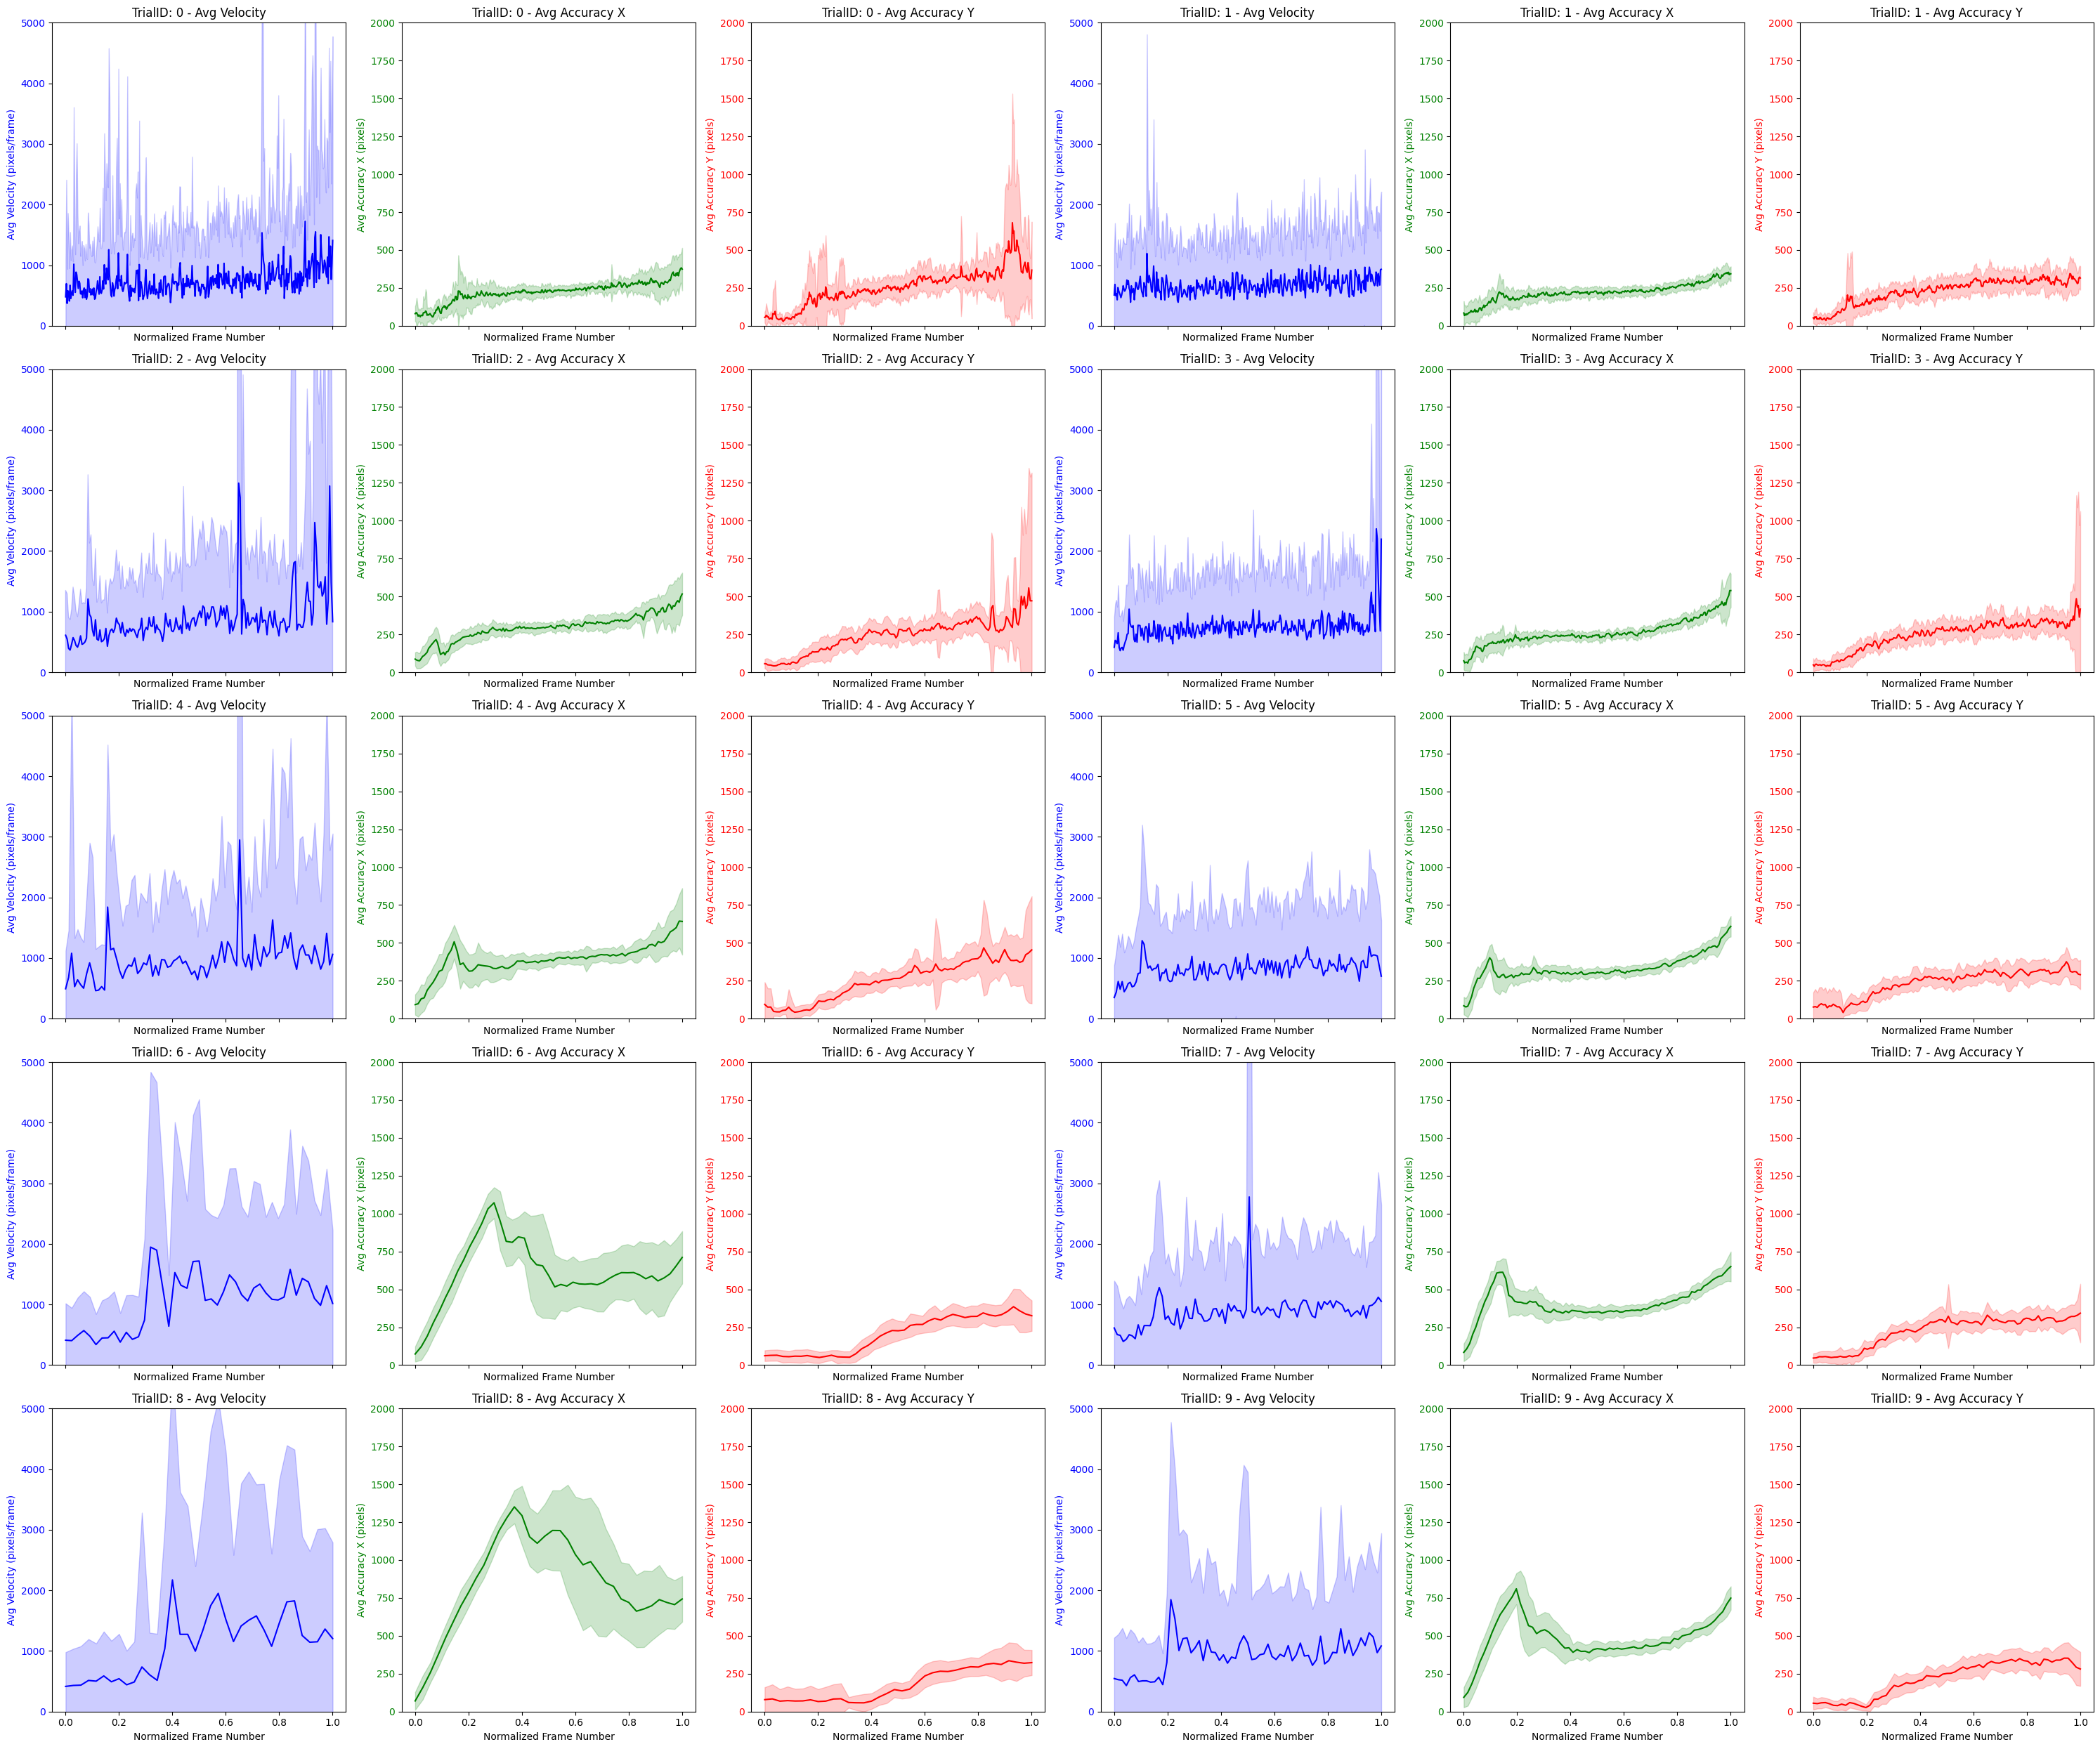

In [36]:
# Step 1: Align frame numbers, normalize to [0, 1], and average across trials of the same type (trialID) with MSE
def align_and_average_across_trials(df, screen_width, screen_height):
    # Align Frame Numbers: Create RelativeFrameNumber for each trial
    df['RelativeFrameNumber'] = df.groupby('TrialNumber')['FrameNumber'].transform(lambda x: x - x.min())
    
    # Compute Velocity and Accuracy
    df = compute_velocity(df)
    df = compute_accuracy(df, screen_width, screen_height)
    
    # Normalize Relative Frame Number to the range [0, 1]
    df['MaxRelativeFrame'] = df.groupby('TrialNumber')['RelativeFrameNumber'].transform('max')
    df['NormalizedFrameNumber'] = df['RelativeFrameNumber'] / df['MaxRelativeFrame']

    # Find the maximum duration (normalized frame number) across all trials
    max_duration = df.groupby('TrialID')['NormalizedFrameNumber'].max().max()

    # Step 2: Interpolate missing values for shorter trials
    all_normalized_frames = pd.DataFrame({'NormalizedFrameNumber': np.linspace(0, max_duration, num=100)})  # You can set 100 or any resolution
    
    avg_df = []
    
    for trial_id in df['TrialID'].unique():
        trial_data = df[df['TrialID'] == trial_id]
    

        # Now calculate mean and MSE across all trials of the same type (trialID)
        avg_by_trial_id = trial_data.groupby('NormalizedFrameNumber').agg(
            AvgVelocity=('Velocity', 'mean'),
            MSEVelocity=('Velocity', lambda x: np.mean((x - x.mean())**2)),
            AvgAccuracyX=('AccuracyX', 'mean'),
            MSEAccuracyX=('AccuracyX', lambda x: np.mean((x - x.mean())**2)),
            AvgAccuracyY=('AccuracyY', 'mean'),
            MSEAccuracyY=('AccuracyY', lambda x: np.mean((x - x.mean())**2))
        ).reset_index()
        
        avg_by_trial_id['TrialID'] = trial_id
        avg_df.append(avg_by_trial_id)

    # Concatenate all averaged trials
    avg_df = pd.concat(avg_df)
    return avg_df

# Step 3: Plot the aligned and averaged metrics by trialID with MSE regions
def plot_aligned_average_metrics_by_trialID(avg_df, screen_width, screen_height):
    trial_ids = sorted(avg_df['TrialID'].unique())  # Ensure TrialIDs are ordered
    num_trials = len(trial_ids)
    num_rows = (num_trials + 1) // 2  # Each row contains 2 trials

    # Create subplots: 6 columns (2 trials per row, each with velocity and X/Y accuracy)
    fig, axes = plt.subplots(num_rows, 6, figsize=(30, 5 * num_rows), sharex=True)

    for i, trial_id in enumerate(trial_ids):
        trial_avg = avg_df[avg_df['TrialID'] == trial_id]

        row = i // 2
        col_velocity = (i % 2) * 3  # First column for velocity
        col_accuracy_x = col_velocity + 1  # Second column for X accuracy
        col_accuracy_y = col_velocity + 2  # Third column for Y accuracy

        # Plot average Velocity and MSE region in the first column for each trialID
        ax_velocity = axes[row, col_velocity]
        ax_velocity.plot(trial_avg['NormalizedFrameNumber'], trial_avg['AvgVelocity'], color='blue', label='Avg Velocity')
        ax_velocity.fill_between(trial_avg['NormalizedFrameNumber'],
                                 trial_avg['AvgVelocity'] - np.sqrt(trial_avg['MSEVelocity']),
                                 trial_avg['AvgVelocity'] + np.sqrt(trial_avg['MSEVelocity']),
                                 color='blue', alpha=0.2, label='MSE Region')
        ax_velocity.set_ylabel('Avg Velocity (pixels/frame)', color='blue')
        ax_velocity.tick_params(axis='y', labelcolor='blue')
        ax_velocity.set_title(f'TrialID: {trial_id} - Avg Velocity')
        ax_velocity.set_ylim([0, 5000])
        ax_velocity.set_xlabel('Normalized Frame Number')

        # Plot average Accuracy (X) and MSE region in the second column for each trial
        ax_accuracy_x = axes[row, col_accuracy_x]
        ax_accuracy_x.plot(trial_avg['NormalizedFrameNumber'], trial_avg['AvgAccuracyX'], color='green', label='Avg Accuracy X')
        ax_accuracy_x.fill_between(trial_avg['NormalizedFrameNumber'],
                                   trial_avg['AvgAccuracyX'] - np.sqrt(trial_avg['MSEAccuracyX']),
                                   trial_avg['AvgAccuracyX'] + np.sqrt(trial_avg['MSEAccuracyX']),
                                   color='green', alpha=0.2, label='MSE Region')
        ax_accuracy_x.set_ylabel('Avg Accuracy X (pixels)', color='green')
        ax_accuracy_x.tick_params(axis='y', labelcolor='green')
        ax_accuracy_x.set_title(f'TrialID: {trial_id} - Avg Accuracy X')
        ax_accuracy_x.set_ylim([0, 2000])
        ax_accuracy_x.set_xlabel('Normalized Frame Number')

        # Plot average Accuracy (Y) and MSE region in the third column for each trial
        ax_accuracy_y = axes[row, col_accuracy_y]
        ax_accuracy_y.plot(trial_avg['NormalizedFrameNumber'], trial_avg['AvgAccuracyY'], color='red', label='Avg Accuracy Y')
        ax_accuracy_y.fill_between(trial_avg['NormalizedFrameNumber'],
                                   trial_avg['AvgAccuracyY'] - np.sqrt(trial_avg['MSEAccuracyY']),
                                   trial_avg['AvgAccuracyY'] + np.sqrt(trial_avg['MSEAccuracyY']),
                                   color='red', alpha=0.2, label='MSE Region')
        ax_accuracy_y.set_ylabel('Avg Accuracy Y (pixels)', color='red')
        ax_accuracy_y.tick_params(axis='y', labelcolor='red')
        ax_accuracy_y.set_title(f'TrialID: {trial_id} - Avg Accuracy Y')
        ax_accuracy_y.set_ylim([0, 2000])
        ax_accuracy_y.set_xlabel('Normalized Frame Number')

    fig.tight_layout()
    plt.show()

# Step 4: Align, average, and plot metrics with normalized frame numbers and MSE regions
aligned_avg_data_by_trial = align_and_average_across_trials(data, screen_width, screen_height)
plot_aligned_average_metrics_by_trialID(aligned_avg_data_by_trial, screen_width, screen_height)


Second half of trials


In [ ]:
# Step 1: Align frame numbers, normalize to [0, 1], and average across the first half of the trials
def align_and_average_across_first_half_trials(df, screen_width, screen_height):
    # Get the unique TrialNumbers and select the first half
    unique_trials = df['TrialNumber'].unique()
    first_half_trial_count = len(unique_trials) // 2
    first_half_trials = unique_trials[:first_half_trial_count]  # Select the first half of the trials
    print(first_half_trial_count)
    
    # Filter the data to only include the first half of the trials
    df_first_half = df[df['TrialNumber'].isin(first_half_trials)]
    
    # Align Frame Numbers: Create RelativeFrameNumber for each trial
    df_first_half['RelativeFrameNumber'] = df_first_half.groupby('TrialNumber')['FrameNumber'].transform(lambda x: x - x.min())
    
    # Compute Velocity and Accuracy
    df_first_half = compute_velocity(df_first_half)
    df_first_half = compute_accuracy(df_first_half, screen_width, screen_height)
    
    # Normalize Relative Frame Number to the range [0, 1]
    df_first_half['MaxRelativeFrame'] = df_first_half.groupby('TrialNumber')['RelativeFrameNumber'].transform('max')
    df_first_half['NormalizedFrameNumber'] = df_first_half['RelativeFrameNumber'] / df_first_half['MaxRelativeFrame']

    # Find the maximum duration (normalized frame number) across all trials
    max_duration = df_first_half.groupby('TrialID')['NormalizedFrameNumber'].max().max()

    # Step 2: Interpolate missing values for shorter trials
    all_normalized_frames = pd.DataFrame({'NormalizedFrameNumber': np.linspace(0, max_duration, num=100)})  # You can set 100 or any resolution
    
    avg_df = []
    
    for trial_id in df_first_half['TrialID'].unique():
        trial_data = df_first_half[df_first_half['TrialID'] == trial_id]
    

        # Now calculate mean and MSE across all trials of the same type (trialID)
        avg_by_trial_id = trial_data.groupby('NormalizedFrameNumber').agg(
            AvgVelocity=('Velocity', 'mean'),
            MSEVelocity=('Velocity', lambda x: np.mean((x - x.mean())**2)),
            AvgAccuracyX=('AccuracyX', 'mean'),
            MSEAccuracyX=('AccuracyX', lambda x: np.mean((x - x.mean())**2)),
            AvgAccuracyY=('AccuracyY', 'mean'),
            MSEAccuracyY=('AccuracyY', lambda x: np.mean((x - x.mean())**2))
        ).reset_index()
        
        avg_by_trial_id['TrialID'] = trial_id
        avg_df.append(avg_by_trial_id)

    # Concatenate all averaged trials
    avg_df = pd.concat(avg_df)
    return avg_df

# Step 2: Plot the aligned and averaged metrics by trialID for the first half of the trials
def plot_aligned_average_metrics_by_trialID_first_half(avg_df, screen_width, screen_height):
    trial_ids = sorted(avg_df['TrialID'].unique())  # Ensure TrialIDs are ordered
    num_trials = len(trial_ids)
    num_rows = (num_trials + 1) // 2  # Each row contains 2 trials

    # Create subplots: 6 columns (2 trials per row, each with velocity and X/Y accuracy)
    fig, axes = plt.subplots(num_rows, 6, figsize=(30, 5 * num_rows), sharex=True)

    for i, trial_id in enumerate(trial_ids):
        trial_avg = avg_df[avg_df['TrialID'] == trial_id]

        row = i // 2
        col_velocity = (i % 2) * 3  # First column for velocity
        col_accuracy_x = col_velocity + 1  # Second column for X accuracy
        col_accuracy_y = col_accuracy_x + 1  # Third column for Y accuracy

        # Plot average Velocity and MSE region in the first column for each trialID
        ax_velocity = axes[row, col_velocity]
        ax_velocity.plot(trial_avg['NormalizedFrameNumber'], trial_avg['AvgVelocity'], color='blue', label='Avg Velocity')
        ax_velocity.fill_between(trial_avg['NormalizedFrameNumber'],
                                 trial_avg['AvgVelocity'] - np.sqrt(trial_avg['MSEVelocity']),
                                 trial_avg['AvgVelocity'] + np.sqrt(trial_avg['MSEVelocity']),
                                 color='blue', alpha=0.2, label='MSE Region')
        ax_velocity.set_ylabel('Avg Velocity (pixels/frame)', color='blue')
        ax_velocity.tick_params(axis='y', labelcolor='blue')
        ax_velocity.set_title(f'TrialID: {trial_id} - Avg Velocity')
        ax_velocity.set_ylim([0, 5000])
        ax_velocity.set_xlabel('Normalized Frame Number')

        # Plot average Accuracy (X) and MSE region in the second column for each trial
        ax_accuracy_x = axes[row, col_accuracy_x]
        ax_accuracy_x.plot(trial_avg['NormalizedFrameNumber'], trial_avg['AvgAccuracyX'], color='green', label='Avg Accuracy X')
        ax_accuracy_x.fill_between(trial_avg['NormalizedFrameNumber'],
                                   trial_avg['AvgAccuracyX'] - np.sqrt(trial_avg['MSEAccuracyX']),
                                   trial_avg['AvgAccuracyX'] + np.sqrt(trial_avg['MSEAccuracyX']),
                                   color='green', alpha=0.2, label='MSE Region')
        ax_accuracy_x.set_ylabel('Avg Accuracy X (pixels)', color='green')
        ax_accuracy_x.tick_params(axis='y', labelcolor='green')
        ax_accuracy_x.set_title(f'TrialID: {trial_id} - Avg Accuracy X')
        ax_accuracy_x.set_ylim([0, 2000])
        ax_accuracy_x.set_xlabel('Normalized Frame Number')

        # Plot average Accuracy (Y) and MSE region in the third column for each trial
        ax_accuracy_y = axes[row, col_accuracy_y]
        ax_accuracy_y.plot(trial_avg['NormalizedFrameNumber'], trial_avg['AvgAccuracyY'], color='red', label='Avg Accuracy Y')
        ax_accuracy_y.fill_between(trial_avg['NormalizedFrameNumber'],
                                   trial_avg['AvgAccuracyY'] - np.sqrt(trial_avg['MSEAccuracyY']),
                                   trial_avg['AvgAccuracyY'] + np.sqrt(trial_avg['MSEAccuracyY']),
                                   color='red', alpha=0.2, label='MSE Region')
        ax_accuracy_y.set_ylabel('Avg Accuracy Y (pixels)', color='red')
        ax_accuracy_y.tick_params(axis='y', labelcolor='red')
        ax_accuracy_y.set_title(f'TrialID: {trial_id} - Avg Accuracy Y')
        ax_accuracy_y.set_ylim([0, 2000])
        ax_accuracy_y.set_xlabel('Normalized Frame Number')

    fig.tight_layout()
    plt.show()

# Step 3: Align, average, and plot metrics for the first half of the trials
aligned_avg_data_first_half = align_and_average_across_first_half_trials(data, screen_width, screen_height)
plot_aligned_average_metrics_by_trialID_first_half(aligned_avg_data_first_half, screen_width, screen_height)
